In [12]:
# goals:
# for each neural dataset, get the data into a reasonable format

## import relevant libraries

In [13]:
import numpy as np
import pandas as pd
import nibabel as nib
import os
import sys
from os import listdir
from os.path import isfile, join, exists
import matplotlib.pyplot as plt
import nilearn.plotting as plotting
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.spatial.distance import pdist, squareform,cosine,euclidean,mahalanobis
from statsmodels.stats.multitest import multipletests
import scipy.io as sio
import scipy.stats as stats
from IPython.core.debugger import set_trace
from tqdm import tqdm
import time
import importlib
import seaborn as sns

sys.path.append('/home/jacobpri/git/RotspaceIT/')
from RotspaceIT import rsatools as rsa

importlib.reload(rsa)


<module 'RotspaceIT.rsatools' from '/home/jacobpri/git/RotspaceIT/RotspaceIT/rsatools.py'>

## hyperparameters

In [14]:
home_dir = '/home/jacobpri/git/RotspaceIT/'
dataset = 'Cohen2017'

## dataset-specific opts

In [15]:
opts = dict()
if dataset == 'Cohen2017':
    opts['datatypes_avail'] = ['univar','rdv']
    opts['levels_avail'] = ['categ']
    opts['data_fn'] = 'RoiRsa_reordered.mat'
    opts['struct_name'] = 'R'
    opts['roi_fieldname'] = 'roiList'
    opts['univar_fieldname'] = 'roiCondMeans'
    opts['rdv_fieldname'] = 'roiRsaSubCube'
    opts['categ_strs'] = np.array(['faces','cats','bodies','cars','hammers','phones','chairs','buildings'])
    opts['plot_order'] = np.array([0,2,1,4,6,7,5,3])
elif dataset == 'Baker2018':
    opts['datatypes_avail'] = ['rdv']
    opts['levels_avail'] = ['categ']
    opts['data_fn'] = 'Baker.mat'
    opts['struct_name'] = 'Baker'
    opts['roi_fieldname'] = 'roiList'
    opts['univar_fieldname'] = []
    opts['rdv_fieldname'] = []
    opts['categ_strs'] = []
    opts['plot_order'] = []

## load fMRI data

In [16]:
data_dir = join('/user_data','jacobpri','Project','RotspaceIT','data','d01_rawdata',dataset)
save_dir = join(home_dir,'data','d03_processing',dataset)

assert(exists(data_dir))
if not exists(save_dir):
    os.makedirs(save_dir)
    
fmri = dict()

assert(exists(data_dir))

if dataset == 'Cohen2017':
    
    # dataset 
    X = sio.loadmat(join(data_dir,opts['data_fn']))[opts['struct_name']]
    
    # 16 ROIs
    roi_list = np.concatenate(X[opts['roi_fieldname']][0][0][0])
    print(roi_list)
    
    # ROIs x subjects x categ pairs
    roi_univar_subcube = X[opts['univar_fieldname']][0][0]
    print(roi_univar_subcube.shape)
    
    roi_rsa_subcube = X[opts['rdv_fieldname']][0][0]
    print(roi_rsa_subcube.shape)
    
    # save this
    
    # average over subjects
    roi_univar_submean = np.nanmean(roi_univar_subcube,axis=1)
    print(roi_univar_submean.shape)
    
    roi_rsa_submean = np.nanmean(roi_rsa_subcube,axis=1)
    print(roi_rsa_submean.shape)
    
    # dictionary of category RDVs by roi. fmri[roi][data][level] (e.g. fmri['FFA']['rdv']['item'])
    for r in range(len(roi_list)):
        
        roi = roi_list[r]
        fmri[roi] = dict()
        
        for datatype in opts['datatypes_avail']:
            
            fmri[roi][datatype] = dict()
            
            for level in opts['levels_avail']:
                
                if datatype == 'univar':
                    fmri[roi][datatype][level] = roi_univar_submean[r]
                elif datatype == 'rdv':
                    fmri[roi][datatype][level] = rsa.rsm2rdm(roi_rsa_submean[r]) # FLIP FROM SIM TO DISSIM
    

    # save relevant files
    #fn = join(save_dir,'fmri_roi_rsa_subcube.npy')
    #np.save(fn, roi_rsa_subcube)
    
    fn = join(save_dir,'fmri_roidata_submean.npy')
    np.save(fn, fmri)
    
    fn = join(save_dir, 'roi_list.npy')
    np.save(fn, roi_list)
    
    
elif dataset == 'Baker2018':
    
    data_dir = join(home_dir,'data','d01_rawdata',dataset)
    save_dir = join(home_dir,'data','d03_processing',dataset)

    roi_list = ['FFA','PPA']
    
    for roi in roi_list:
        fmri[roi] = dict()
        X = sio.loadmat(join(data_dir,f'Baker_{roi}_RDM_categ_both'))[f'Baker_{roi}_RDM_categ_both']
        
        for datatype in opts['datatypes_avail']:
            
            fmri[roi][datatype] = dict()
            
            for level in opts['levels_avail']:
                
                if datatype == 'univar':
                    pass
                elif datatype == 'rdv':
                    fmri[roi][datatype][level] = rsa.m2v(X) # FLIP FROM RDM to RDV
    

    # save relevant files
    #fn = join(save_dir,'fmri_roi_rsa_subcube.npy')
    #np.save(fn, roi_rsa_subcube)
    
    fn = join(save_dir,'fmri_roidata_submean.npy')
    np.save(fn, fmri)
    
    fn = join(save_dir, 'roi_list.npy')
    np.save(fn, roi_list)

['FFA' 'OFA' 'FBA' 'EBA' 'LO' 'PPA' 'TOS' 'MT' 'VentralOTC' 'LateralOTC'
 'OPC' 'EarlyV2' 'VentralOTCRemoved' 'LateralOTCRemoved' 'OPCRemoved'
 'EarlyV2Removed']
(16, 6, 8)
(16, 6, 28)
(16, 8)
(16, 28)


In [17]:
rsa.v2m(fmri['FFA']['rdv']['categ'])

array([[0.        , 0.16563835, 0.08880824, 0.30911428, 0.17701856,
        0.24211344, 0.21088889, 0.21113799],
       [0.16563835, 0.        , 0.09493638, 0.31928501, 0.16356578,
        0.14211037, 0.11550473, 0.18149842],
       [0.08880824, 0.09493638, 0.        , 0.31020508, 0.16648295,
        0.19051192, 0.15559046, 0.21151001],
       [0.30911428, 0.31928501, 0.31020508, 0.        , 0.15369883,
        0.15585741, 0.22566185, 0.14318346],
       [0.17701856, 0.16356578, 0.16648295, 0.15369883, 0.        ,
        0.09706995, 0.10109991, 0.08497287],
       [0.24211344, 0.14211037, 0.19051192, 0.15585741, 0.09706995,
        0.        , 0.09780855, 0.10527253],
       [0.21088889, 0.11550473, 0.15559046, 0.22566185, 0.10109991,
        0.09780855, 0.        , 0.0940297 ],
       [0.21113799, 0.18149842, 0.21151001, 0.14318346, 0.08497287,
        0.10527253, 0.0940297 , 0.        ]])

[[0.         0.08880824 0.16563835 0.17701856 0.21088889 0.21113799
  0.24211344 0.30911428]
 [0.08880824 0.         0.09493638 0.16648295 0.15559046 0.21151001
  0.19051192 0.31020508]
 [0.16563835 0.09493638 0.         0.16356578 0.11550473 0.18149842
  0.14211037 0.31928501]
 [0.17701856 0.16648295 0.16356578 0.         0.10109991 0.08497287
  0.09706995 0.15369883]
 [0.21088889 0.15559046 0.11550473 0.10109991 0.         0.0940297
  0.09780855 0.22566185]
 [0.21113799 0.21151001 0.18149842 0.08497287 0.0940297  0.
  0.10527253 0.14318346]
 [0.24211344 0.19051192 0.14211037 0.09706995 0.09780855 0.10527253
  0.         0.15585741]
 [0.30911428 0.31020508 0.31928501 0.15369883 0.22566185 0.14318346
  0.15585741 0.        ]]


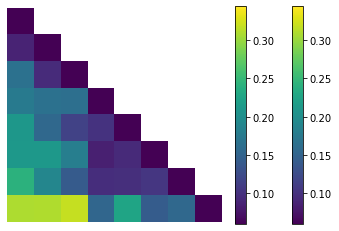

In [18]:
plt.figure()
mat = rsa.v2m(fmri['FFA']['rdv']['categ'])
i = np.diag_indices(mat.shape[0])
mat[i] = 0
if dataset == 'Cohen2017':
    mat = mat[opts['plot_order']]#
    mat = mat[:,opts['plot_order']]
vals = mat[:]
print(vals)
minv = np.min(vals[vals!=0])-0.025
maxv = np.min([np.max(vals[vals!=0]+0.025), 1.2])
plt.imshow(mat,clim=(minv,maxv))
plt.colorbar()
plt.show()

triu = np.triu_indices(mat.shape[0])
data = mat

masked_array = np.ma.masked_where(np.triu(mat), data)

cmap = plt.cm.viridis  # Can be any colormap that you want after the cm
cmap.set_bad(color='white')

plt.imshow(masked_array, cmap=cmap, clim=(minv,maxv))
plt.axis('off')
plt.colorbar()
plt.show()



In [19]:
print(np.corrcoef(fmri['FFA']['rdv']['categ'],fmri['PPA']['rdv']['categ']))

[[1.         0.81185753]
 [0.81185753 1.        ]]


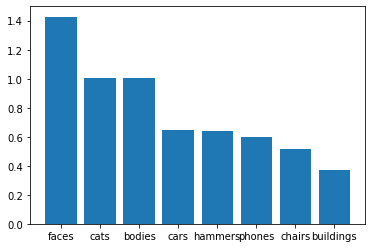

In [20]:
plt.figure()
vec = fmri['FFA']['univar']['categ'][opts['plot_order']]
plt.bar(np.arange(8),vec)
plt.xticks(np.arange(8),opts['categ_strs']);
plt.show()


(16, 6, 28)
(16, 6, 28)
(16, 28)
(28,)
(28,)
0.8118575265004265


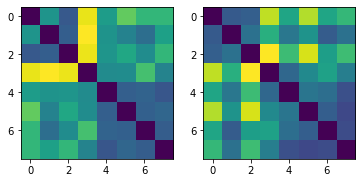

In [21]:
def rsm2rdm(X):
    return ((X - 1) * -1)

fmri_dir = '/home/jacobpri/RotspaceIT/CohenfMRIData/'

Cohen = sio.loadmat(join(fmri_dir,'RoiRsa_reordered.mat'))['R']
#print(Cohen)
roi_list = Cohen['roiList'][0]

FFA_idx = 0
PPA_idx = 5
#print(roi_list)
#print(Cohen)
print(Cohen['roiRsaSubCube'][0,0].shape)
R = Cohen['roiRsaSubCube'][0,0]
print(R.shape)
R_ = np.nanmean(R,axis=1)
print(R_.shape)
subj_FFA_rdv = R_[FFA_idx,:]
subj_PPA_rdv = R_[PPA_idx,:]
print(subj_FFA_rdv.shape)
#Cohen['roiCondRSA'].shape
#plt.figure()
#plt.imshow(subj_FFA_rdv,aspect='auto',clim=(0,1.5))
#plt.colorbar()

avg_FFA_rdv = subj_FFA_rdv#np.nanmean(subj_FFA_rdv,axis=0)
avg_PPA_rdv = subj_PPA_rdv#np.nanmean(subj_PPA_rdv,axis=0)
print(avg_FFA_rdv.shape)

print(np.corrcoef(avg_FFA_rdv,avg_PPA_rdv)[0,1])

plt.figure()
plt.subplot(121)
plt.imshow(squareform(rsm2rdm(avg_FFA_rdv)))
plt.subplot(122)
plt.imshow(squareform(rsm2rdm(avg_PPA_rdv)))